# WORKFLOW

* SVM on simple features 
* MLP on simple features
* MLP on whole signal
* MLP on whole Fourier Transform
* CNN1D on whole signal
* CNN1D on Mel-Frequency Cepstral Coefficients

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AGz9Xg4pqy1ikkDXX62e_F21f9iVzfZV-2rkNSWHcRcUocg6YOVm08
Mounted at /content/drive


In [2]:
path='/content/drive/My Drive/DSIM/recordings/'

In [3]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
from scipy.fftpack import rfft, fft, irfft, ifft, fftfreq
from scipy.signal import fftconvolve

import matplotlib.pyplot as plt
import IPython.display as ipd

# Strumenti di classificazione
# SVM from sci-kit-learn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
# NNs from keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool2D, MaxPool1D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import GRU

# SVM on Extracted Features

In this section we define data loader function and feature extraction functions (particularly absolute average, standard deviation, energy and zcr of the signal). Analogous functions for the MLP to come.

In [ ]:
# Segnaposto per feature extractor
def identity(input):
    return input

# Data loader
def svm_load_data(feature_extractor=identity, normalize=True):

    labels = []
    features = []

    for f in sorted(os.listdir('/content/drive/My Drive/DSIM/recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('/content/drive/My Drive/DSIM/recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[1]
            if label not in ('alessandro', 'fabrice', 'davide'):
                label = 'unknown_person'
            labels.append(label)
        else:
            print(f)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [8]:
# Funzioni di Preprocessing
def crop(input, size=100):
    # Elimina eventuali valori oltre il numero consentito
    output = input[0:min(size, input.shape[0])]
    # Aggiungi valori nulli per raggiungere la dimensione richiesta
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output
def svm_sdev(input):
    return np.std(input, keepdims=True)
def svm_avg(input):
    return np.mean(input, keepdims=True)

def svm_aavg(input):
    return np.mean(np.abs(input), keepdims=True)
def svm_duration(input):
    return input.shape
def svm_energy(input):
    return np.sum((input*1.0)**2, keepdims=True)
def svm_zcr(input):
    padinput = np.array(crop(input, input.shape[0]+1)) 
    # si aggiunge alla sequenza un termine nullo, per avere lo slot per il segnale 1-lag
    
    scsv = np.zeros_like(padinput) # segnale 1-lag inizializzato a valori nulli 
    scsv[1:] = np.array(crop(input, input.shape[0])) # valori del segnale originale inseriti con lag pari a 1
    
    zc_count = 0.5*np.sum(np.absolute(np.sign(padinput)-np.sign(scsv)))
    # cfr formula scritta sopra, qui la sommatoria ha una finestra pari alla lunghezza dei segnali
    # si deve passare da frequenza assoluta a relativa
    zc_rate = zc_count / len(padinput)
    
    return (zc_rate, )

In [ ]:
# Feature Extractor
def svm_combo_zcr(input):
    return np.concatenate((svm_aavg(input),svm_sdev(input),svm_energy(input),svm_zcr(input)))

In [5]:
# Save/Load
def saver(array, name):
  file = open(name, "wb")
  # save array to the file
  np.save(file, array)
  # close the file
  file.close()
def loader(name):
  # open the file in read binary mode
  file = open(name, "rb")
  #read the file to numpy array
  arr1 = np.load(file, allow_pickle=True)
  #close the file
  file.close()
  return arr1

In [ ]:
path='/content/drive/My Drive/DSIM/recordings/'

In [ ]:
# Caricamento dati
#svmX_train, svmX_test, svmy_train, svmy_test = svm_load_data(feature_extractor=svm_combo_zcr)

#saver(svmX_train,path+'svmX_train'); saver(svmX_test, path+'svmX_test'); saver(svmy_train, path+'svmy_train'); saver(svmy_test,path+'svmy_test');
svmX_train=loader(path+'svmX_train'); svmX_test=loader(path+'svmX_test'); svmy_train=loader(path+'svmy_train'); svmy_test=loader(path+'svmy_test');


# Parametri da provare in cross validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Inizializzazione Support Vector Machine
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Addestramento
t0 = time()
clf = clf.fit(svmX_train, svmy_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

Addestramento completato in 0.987s


In [ ]:
# Risultato della cross validation per la selezione dei parametri
print("Migliore combinazione di parametri:")
print(" C: "+str(clf.best_estimator_.C))
print(" gamma: "+str(clf.best_estimator_.gamma))

Migliore combinazione di parametri:
 C: 500.0
 gamma: 0.01


Report di classificazione:
                precision    recall  f1-score   support

    alessandro       0.89      0.99      0.94       118
        davide       0.92      0.78      0.85       106
       fabrice       0.92      0.95      0.94       115
unknown_person       1.00      1.00      1.00       310

      accuracy                           0.95       649
     macro avg       0.93      0.93      0.93       649
  weighted avg       0.95      0.95      0.95       649

Matrice di confusione:
[[117   1   0   0]
 [ 14  83   9   0]
 [  0   6 109   0]
 [  0   0   0 310]]


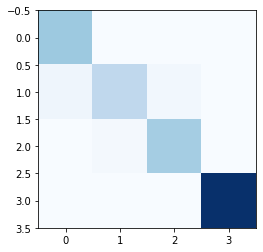

In [ ]:
# Test
svmy_pred = clf.predict(svmX_test)

# Report di classificazione
print("Report di classificazione:")
print(classification_report(svmy_test, svmy_pred))

# Matrice di confusione
print("Matrice di confusione:")
cm = confusion_matrix(svmy_test, svmy_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [ ]:
X_whole = np.concatenate((svmX_train, svmX_test), axis=0)
y_whole = np.concatenate((svmy_train, svmy_test), axis=0)

clf.fit(X_whole, y_whole)

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf.best_estimator_, path+'svm.pkl', compress=1)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/content/drive/My Drive/DSIM/recordings/svm.pkl']

# MLP on Extracted Features

Instantiation of MLP with same features as fed to SVM

In [ ]:
def mlp_load_data(feature_extractor=identity, normalize=True):

    labels = []
    features = []
    labelling = {'alessandro': 1,
                'fabrice': 2,
                'davide': 3,
                'unknown_person':0}

    for f in sorted(os.listdir('/content/drive/My Drive/DSIM/recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('/content/drive/My Drive/DSIM/recordings/' + f)
            cur_features = feature_extractor(signal)
            cur_features = np.asarray(cur_features)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[1]
            if label not in ('alessandro', 'fabrice', 'davide'):
                label = 'unknown_person'
            label = labelling[label]
            labels.append(label)
        else:
            print(f)

    # X: features, y: labels
    num_classes = len(labelling)
    X_train, X_test, y_train, y_test = train_test_split(np.asarray(features), np.asarray(labels), test_size=0.2, random_state=1)
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]
        
        X_train = np.asarray(X_train)
        X_test = np.asarray(X_test)

    return X_train, X_test, y_train, y_test, num_classes

In [ ]:
def sdev(input):
    sdv = np.std(input)
    sdv = np.asarray(sdv)
    return sdv
def avg(input):
    avg = np.mean(input)
    avg = np.asarray(sdv)
    return avg
def aavg(input):
    aavg = np.mean(np.abs(input))
    aavg = np.asarray(aavg)
    return aavg
def duration(input):
    dura = input.shape[0]
    dura = np.asarray(input.shape[0])
    return dura
def energy(input):
    ene = np.sum((input*1.0)**2)
    ene = np.asarray(ene)
    return ene
def zcr(input):
    padinput = np.array(crop(input, input.shape[0]+1)) 
    # si aggiunge alla sequenza un termine nullo, per avere lo slot per il segnale 1-lag
    
    scsv = np.zeros_like(padinput) # segnale 1-lag inizializzato a valori nulli 
    scsv[1:] = np.array(crop(input, input.shape[0])) # valori del segnale originale inseriti con lag pari a 1
    
    zc_count = 0.5*np.sum(np.absolute(np.sign(padinput)-np.sign(scsv)))
    # cfr formula scritta sopra, qui la sommatoria ha una finestra pari alla lunghezza dei segnali
    # si deve passare da frequenza assoluta a relativa
    zc_rate = zc_count / len(padinput)
    zc_rate = np.asarray(zc_rate)
    return zc_rate
def combo_zcr(input):
    return list((aavg(input),sdev(input),energy(input),zcr(input)))

In [ ]:
#X_train, X_test, y_train, y_test, num_classes = mlp_load_data(feature_extractor=combo_zcr, normalize=True)
#saver(X_train,path+'X_train_mlpfeat'); saver(X_test, path+'X_test_mlpfeat'); saver(y_train, path+'y_train_mlpfeat'); saver(y_test,path+'y_test_mlpfeat');
X_train=loader(path+'X_train_mlpfeat'); X_test=loader(path+'X_test_mlpfeat'); y_train=loader(path+'y_train_mlpfeat'); y_test=loader(path+'y_test_mlpfeat'); num_classes=4;

X_train[0]

array([ 0.97952555,  0.90985981,  0.02543129, -0.30120914])

In [ ]:
# MLP su classificazione voci
dims = X_train.shape[1]

mlp = Sequential()
mlp.add(Dense(32, input_shape=(dims,), activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

mlp.summary()
mlp.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 756
Trainable params: 756
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t0 = time()
mlp_history = mlp.fit(X_train, y_train, epochs=18, batch_size=64, verbose=True, validation_data=(X_test, y_test))
print("Addestramento completato in %0.3fs" % (time() - t0))

Epoch 1/18
41/41 [==============================] - 0s 6ms/step - loss: 1.3169 - accuracy: 0.4873 - val_loss: 1.1382 - val_accuracy: 0.6780
Epoch 2/18
41/41 [==============================] - 0s 3ms/step - loss: 0.9798 - accuracy: 0.7664 - val_loss: 0.8513 - val_accuracy: 0.7458
Epoch 3/18
41/41 [==============================] - 0s 3ms/step - loss: 0.7354 - accuracy: 0.7895 - val_loss: 0.6812 - val_accuracy: 0.7735
Epoch 4/18
41/41 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.8130 - val_loss: 0.5940 - val_accuracy: 0.7889
Epoch 5/18
41/41 [==============================] - 0s 3ms/step - loss: 0.5367 - accuracy: 0.8412 - val_loss: 0.5293 - val_accuracy: 0.8197
Epoch 6/18
41/41 [==============================] - 0s 3ms/step - loss: 0.4815 - accuracy: 0.8562 - val_loss: 0.4806 - val_accuracy: 0.8166
Epoch 7/18
41/41 [==============================] - 0s 3ms/step - loss: 0.4372 - accuracy: 0.8597 - val_loss: 0.4443 - val_accuracy: 0.8166
Epoch 8/18
41/41 [==

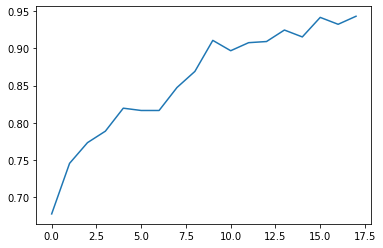

In [ ]:
plt.plot(mlp_history.history['val_accuracy'])

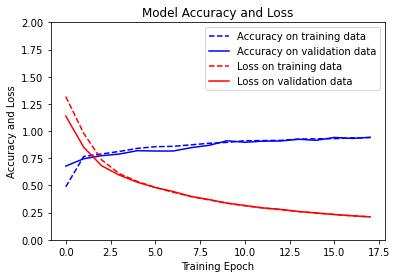

In [ ]:
plt.plot(mlp_history.history['accuracy'], "b--", label="Accuracy on training data")
plt.plot(mlp_history.history['val_accuracy'], "b", label="Accuracy on validation data")
plt.plot(mlp_history.history['loss'], "r--", label="Loss on training data")
plt.plot(mlp_history.history['val_loss'], "r", label="Loss on validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0,2)
plt.legend()
plt.show()

In [ ]:
delabelling = {1: 'alessandro',
                2: 'fabrice',
                3: 'davide',
                0: 'unknown_person'}

def ricateg(y_pred):
    y_pred = [y_pred.argmax(1)]
    y_pred = [delabelling[y_pred[0][i]] for i in range(len(y_pred[0]))]
    return y_pred

Report di classificazione:
                precision    recall  f1-score   support

    alessandro       0.88      0.96      0.91       118
        davide       0.88      0.78      0.83       106
       fabrice       0.92      0.95      0.93       115
unknown_person       1.00      0.99      1.00       310

      accuracy                           0.94       649
     macro avg       0.92      0.92      0.92       649
  weighted avg       0.94      0.94      0.94       649

Matrice di confusione:
[[113   5   0   0]
 [ 13  83  10   0]
 [  0   6 109   0]
 [  3   0   0 307]]


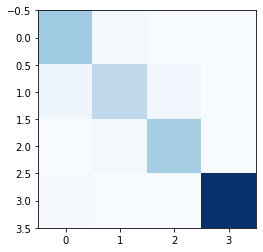

In [ ]:
# Test
y_pred = mlp.predict(X_test)
y_pred_cr = ricateg(y_pred)
y_test_cr = ricateg(y_test)
# Report di classificazione
print("Report di classificazione:")
print(classification_report(y_test_cr, y_pred_cr))

# Matrice di confusione
print("Matrice di confusione:")
mlp_cm = confusion_matrix(y_test_cr, y_pred_cr)
print(mlp_cm)
plt.imshow(mlp_cm, cmap=plt.cm.Blues)

In [ ]:
mlp.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])
X_whole = np.concatenate((X_train, X_test), axis=0)
y_whole = np.concatenate((y_train, y_test), axis=0)

In [ ]:
mlp.save(path+'mlp')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/DSIM/recordings/mlp/assets


Performance quite similar to that of SVM

# MLP on Signal

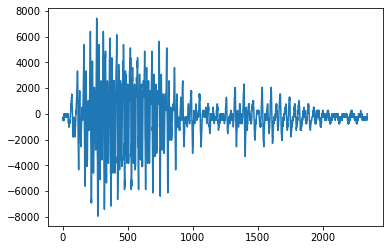

In [6]:
#X_train, X_test, y_train, y_test, num_classes = mlp_load_data(normalize=False)
#saver(X_train,path+'X_train_mlpsig'); saver(X_test, path+'X_test_mlpsig'); saver(y_train, path+'y_train_mlpsig'); saver(y_test,path+'y_test_mlpsig');
X_train=loader(path+'X_train_mlpsig'); X_test=loader(path+'X_test_mlpsig'); y_train=loader(path+'y_train_mlpsig'); y_test=loader(path+'y_test_mlpsig'); num_classes=4;

plt.plot(X_train[0])

In [9]:
lengths = [len(X_train[i]) for i in range(len(X_train))]
max_length = np.max(lengths)
X_train = [crop(X_train[i], max_length) for i in range(len(X_train))]
X_train = np.asarray(X_train)
X_test = [crop(X_test[i], max_length) for i in range(len(X_test))]
X_test = np.asarray(X_test)

In [ ]:
max_length

In [11]:
dims = max_length

mlpss = Sequential()
mlpss.add(Dense(256, input_shape=(dims,), activation='relu'))
mlpss.add(Dense(128, activation='relu'))
mlpss.add(Dense(num_classes))
mlpss.add(Activation('softmax'))

mlpss.summary()
mlpss.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33869056  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 33,902,468
Trainable params: 33,902,468
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t0 = time()
mlpss_history = mlpss.fit(X_train, y_train, epochs=10, batch_size=64, verbose=True, validation_data=(X_test, y_test))
print("Addestramento completato in %0.3fs" % (time() - t0))

Epoch 1/10
41/41 [==============================] - 1s 36ms/step - loss: 15.1355 - accuracy: 0.4981 - val_loss: 1.0055 - val_accuracy: 0.5824
Epoch 2/10
41/41 [==============================] - 1s 28ms/step - loss: 0.7283 - accuracy: 0.7363 - val_loss: 0.9190 - val_accuracy: 0.6780
Epoch 3/10
41/41 [==============================] - 1s 29ms/step - loss: 0.4103 - accuracy: 0.9399 - val_loss: 0.8715 - val_accuracy: 0.7365
Epoch 4/10
41/41 [==============================] - 1s 28ms/step - loss: 0.2850 - accuracy: 0.9931 - val_loss: 0.8363 - val_accuracy: 0.7504
Epoch 5/10
41/41 [==============================] - 1s 28ms/step - loss: 0.2046 - accuracy: 0.9985 - val_loss: 0.8165 - val_accuracy: 0.7581
Epoch 6/10
41/41 [==============================] - 1s 29ms/step - loss: 0.1470 - accuracy: 0.9988 - val_loss: 0.8033 - val_accuracy: 0.7627
Epoch 7/10
41/41 [==============================] - 1s 28ms/step - loss: 0.1064 - accuracy: 0.9988 - val_loss: 0.7983 - val_accuracy: 0.7673
Epoch 8/10
4

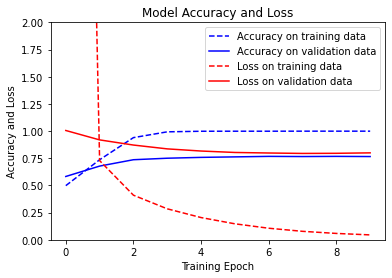

In [ ]:
plt.plot(mlpss_history.history['accuracy'], "b--", label="Accuracy on training data")
plt.plot(mlpss_history.history['val_accuracy'], "b", label="Accuracy on validation data")
plt.plot(mlpss_history.history['loss'], "r--", label="Loss on training data")
plt.plot(mlpss_history.history['val_loss'], "r", label="Loss on validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0,2)
plt.legend()
plt.show()

Report di classificazione:
                precision    recall  f1-score   support

    alessandro       0.64      0.63      0.63       118
        davide       0.55      0.63      0.59       106
       fabrice       0.94      0.40      0.56       115
unknown_person       0.85      1.00      0.92       310

      accuracy                           0.77       649
     macro avg       0.75      0.66      0.68       649
  weighted avg       0.78      0.77      0.75       649

Matrice di confusione:
[[ 74  43   0   1]
 [ 28  67   3   8]
 [ 14  11  46  44]
 [  0   0   0 310]]


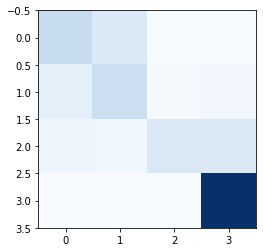

In [ ]:
# Test
y_pred = mlpss.predict(X_test)
y_pred_cr = ricateg(y_pred)
y_test_cr = ricateg(y_test)
# Report di classificazione
print("Report di classificazione:")
print(classification_report(y_test_cr, y_pred_cr))

# Matrice di confusione
print("Matrice di confusione:")
mlpss_cm = confusion_matrix(y_test_cr, y_pred_cr)
print(mlpss_cm)
plt.imshow(mlpss_cm, cmap=plt.cm.Blues)

Overfitting problem, padding problem (for padded sequences, most inputs are silenced). The architecture doesn't account for the sequential nature of the data. We will continue overriding the problem, first with a strong dropout to randomize the access to "sequential" information per hidden units, then moving to the frequency domain.


In [12]:
mlpss = Sequential()
mlpss.add(Dense(256, input_shape=(dims,), activation='relu'))
mlpss.add(Dropout(.66))
mlpss.add(Dense(128, activation='relu'))
mlpss.add(Dropout(.5))
mlpss.add(Dense(num_classes))
mlpss.add(Activation('softmax'))

mlpss.summary()
mlpss.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               33869056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 33,902,468
Trainable params: 33,902,468
Non-trainable params: 0
__________________________________________

In [13]:
t0 = time()
mlpss_history = mlpss.fit(X_train, y_train, epochs=12, batch_size=64, verbose=True, validation_data=(X_test, y_test))
print("Addestramento completato in %0.3fs" % (time() - t0))

Epoch 1/12
41/41 [==============================] - 14s 349ms/step - loss: 71.1610 - accuracy: 0.4329 - val_loss: 1.0946 - val_accuracy: 0.4823
Epoch 2/12
41/41 [==============================] - 14s 334ms/step - loss: 1.2941 - accuracy: 0.5389 - val_loss: 1.0909 - val_accuracy: 0.5439
Epoch 3/12
41/41 [==============================] - 14s 336ms/step - loss: 1.4232 - accuracy: 0.6153 - val_loss: 1.0292 - val_accuracy: 0.6009
Epoch 4/12
41/41 [==============================] - 14s 336ms/step - loss: 1.1100 - accuracy: 0.6715 - val_loss: 0.9613 - val_accuracy: 0.6394
Epoch 5/12
41/41 [==============================] - 14s 336ms/step - loss: 2.2680 - accuracy: 0.7197 - val_loss: 0.9486 - val_accuracy: 0.6703
Epoch 6/12
41/41 [==============================] - 14s 338ms/step - loss: 0.9659 - accuracy: 0.7429 - val_loss: 0.8995 - val_accuracy: 0.6980
Epoch 7/12
41/41 [==============================] - 14s 335ms/step - loss: 1.0787 - accuracy: 0.7606 - val_loss: 0.9262 - val_accuracy: 0.710

In [ ]:
mlpss.save(path+'mlpss')

INFO:tensorflow:Assets written to: /content/drive/My Drive/DSIM/recordings/mlpss/assets


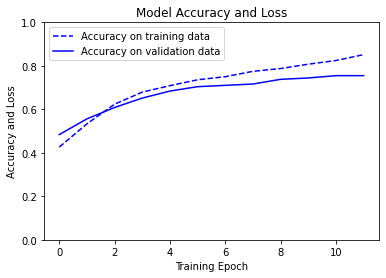

In [ ]:
plt.plot(mlpss_history.history['accuracy'], "b--", label="Accuracy on training data")
plt.plot(mlpss_history.history['val_accuracy'], "b", label="Accuracy on validation data")
#plt.plot(mlpss_history.history['loss'], "r--", label="Loss on training data")
#plt.plot(mlpss_history.history['val_loss'], "r", label="Loss on validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0,1)
plt.legend()
plt.show()

# MLP on Fourier Transform

Applying (right) Fourier Transform and training MLP to recognize voice based on frequency intensities

In [ ]:
# Trasformata destra di Fourier per train set
#X_train_ft = [rfft(signal) for signal in X_train]
#X_train_ft = np.asarray(X_train_ft)
#plt.plot(X_train_ft[0])

In [ ]:
# Troncamento dell'input
#X_train_ft = [trunc[:50000] for trunc in X_train_ft]
#X_train_ft = np.asarray(X_train_ft)

# Trasformata del test e troncamento
#X_test_ft = [rfft(signal) for signal in X_test]
#X_test_ft = np.asarray(X_test_ft)
#X_test_ft = [trunc[:50000] for trunc in X_test_ft]
#X_test_ft = np.asarray(X_test_ft)

In [ ]:
#saver(X_train_ft,path+'X_train_ft');saver(X_test_ft,path+'X_test_ft')

X_train_ft=loader(path+'X_train_ft'); X_test_ft=loader(path+'X_test_ft');

In [ ]:
dims = X_train_ft.shape[1]
num_classes = 4

mlpft = Sequential()
mlpft.add(Dense(512, input_shape=(dims,), activation='relu'))
#mlpft.add(Dropout(.5))
mlpft.add(Dense(256, activation='relu'))
#mlpft.add(Dropout(.5))
mlpft.add(Dense(num_classes))
mlpft.add(Activation('softmax'))

mlpft.summary()
mlpft.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               67738112  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 67,870,468
Trainable params: 67,870,468
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t0 = time()
mlpft_history = mlpft.fit(X_train_ft, y_train, epochs=12, batch_size=64, verbose=True, validation_data=(X_test_ft, y_test))
print("Addestramento completato in %0.3fs" % (time() - t0))

Epoch 1/12
41/41 [==============================] - 2s 48ms/step - loss: 1709.0320 - accuracy: 0.4510 - val_loss: 60.4916 - val_accuracy: 0.4777
Epoch 2/12
41/41 [==============================] - 1s 35ms/step - loss: 41.8592 - accuracy: 0.4599 - val_loss: 54.2168 - val_accuracy: 0.4777
Epoch 3/12
41/41 [==============================] - 1s 34ms/step - loss: 3630.0957 - accuracy: 0.4934 - val_loss: 39.9279 - val_accuracy: 0.4792
Epoch 4/12
41/41 [==============================] - 1s 35ms/step - loss: 20.6682 - accuracy: 0.4838 - val_loss: 51.3426 - val_accuracy: 0.4869
Epoch 5/12
41/41 [==============================] - 1s 35ms/step - loss: 10.1796 - accuracy: 0.6284 - val_loss: 34.3923 - val_accuracy: 0.5177
Epoch 6/12
41/41 [==============================] - 1s 35ms/step - loss: 3.7958 - accuracy: 0.7806 - val_loss: 27.5846 - val_accuracy: 0.5347
Epoch 7/12
41/41 [==============================] - 1s 34ms/step - loss: 1.7283 - accuracy: 0.8512 - val_loss: 26.0977 - val_accuracy: 0.54

Poor results. Cutting frequencies, filtering may help, but we would rather accept the architecture is not the best fit for the problem presented.

In [ ]:
mlpft.save(path+'mlpft')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/DSIM/recordings/mlpft/assets


# CNN on Signal

We will apply a 1-D CNN to the signal, looking for temporal patterns of sound intensity as vocal identity fingerprints

In [ ]:
X_train=loader(path+'X_train_mlpsig'); X_test=loader(path+'X_test_mlpsig'); y_train=loader(path+'y_train_mlpsig'); y_test=loader(path+'y_test_mlpsig'); num_classes=4;

lengths = [len(X_train[i]) for i in range(len(X_train))]
max_length = np.max(lengths)
X_train = [crop(X_train[i], max_length) for i in range(len(X_train))]
X_train = np.asarray(X_train)
X_test = [crop(X_test[i], max_length) for i in range(len(X_test))]
X_test = np.asarray(X_test)

In [ ]:
# CNN shape adjustments (batch, length, "features")

n_train = X_train.shape[0]
n_test = X_test.shape[0]
X_train_cnn = X_train.reshape(n_train,max_length,1)
X_test_cnn = X_test.reshape(n_test,max_length,1)
y_train_cnn = y_train.reshape(n_train,num_classes)
y_test_cnn = y_test.reshape(n_test,num_classes)

In [ ]:
# CNN on signal
cnn = Sequential()
cnn.add(Conv1D(filters=128, kernel_size=12, input_shape=(max_length,1), activation='relu'))
cnn.add(MaxPool1D(pool_size=3, padding='valid'))
cnn.add(Conv1D(filters=128, kernel_size=12, activation='relu'))
cnn.add(MaxPool1D(pool_size=3, padding='valid'))
cnn.add(Flatten())
cnn.add(Dense(128))
cnn.add(Dense(32))
cnn.add(Dense(num_classes))
cnn.add(Activation('softmax'))

cnn.summary()
cnn.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 132289, 128)       1664      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44096, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44085, 128)        196736    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14695, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1880960)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               240763008 
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4

In [ ]:
t0 = time()
cnn_history = cnn.fit(X_train_cnn, y_train_cnn, epochs=4, batch_size=16, verbose=True, validation_data=(X_test_cnn, y_test_cnn))
print("Addestramento completato in %0.3fs" % (time() - t0))

Epoch 1/4
163/163 [==============================] - 185s 1s/step - loss: 0.5033 - accuracy: 0.8107 - val_loss: 20.6723 - val_accuracy: 0.8921
Epoch 2/4
163/163 [==============================] - 184s 1s/step - loss: 0.2150 - accuracy: 0.8982 - val_loss: 39.7271 - val_accuracy: 0.8983
Epoch 3/4
163/163 [==============================] - 185s 1s/step - loss: 0.1368 - accuracy: 0.9476 - val_loss: 33.1584 - val_accuracy: 0.8921
Epoch 4/4
163/163 [==============================] - 185s 1s/step - loss: 0.1153 - accuracy: 0.9572 - val_loss: 33.7770 - val_accuracy: 0.9122
Addestramento completato in 750.018s


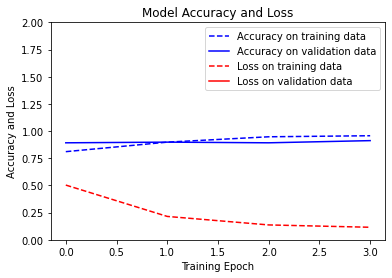

In [ ]:
plt.plot(cnn_history.history['accuracy'], "b--", label="Accuracy on training data")
plt.plot(cnn_history.history['val_accuracy'], "b", label="Accuracy on validation data")
plt.plot(cnn_history.history['loss'], "r--", label="Loss on training data")
plt.plot(cnn_history.history['val_loss'], "r", label="Loss on validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0,2)
plt.legend()
plt.show()

Results are the best since we approached the whole (standardized) data instead of processing and extracting features. The architecture is promising, but heavy with many parameters. Let's try a lighter model.

In [ ]:
# CNN on signal
cnn2 = Sequential()
cnn2.add(Conv1D(filters=64, kernel_size=24, input_shape=(max_length,1), activation='relu'))
cnn2.add(MaxPool1D(pool_size=9, padding='valid'))
cnn2.add(Conv1D(filters=64, kernel_size=24, activation='relu'))
cnn2.add(Dropout(0.5))
cnn2.add(MaxPool1D(pool_size=9, padding='valid'))
cnn2.add(Flatten())
cnn2.add(Dropout(0.5))
cnn2.add(Dense(128))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(32))
cnn2.add(Dense(num_classes))
cnn2.add(Activation('softmax'))

cnn2.summary()
cnn2.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 132277, 64)        1600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14697, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14674, 64)         98368     
_________________________________________________________________
dropout (Dropout)            (None, 14674, 64)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1630, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 104320)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 104320)            0

In [ ]:
t0 = time()
cnn2_history = cnn2.fit(X_train_cnn, y_train_cnn, epochs=6, batch_size=16, verbose=True, validation_data=(X_test_cnn, y_test_cnn))
print("Addestramento completato in %0.3fs" % (time() - t0))

Epoch 1/6
163/163 [==============================] - 42s 255ms/step - loss: 3.7131 - accuracy: 0.8211 - val_loss: 0.3121 - val_accuracy: 0.8783
Epoch 2/6
163/163 [==============================] - 41s 251ms/step - loss: 0.3126 - accuracy: 0.8697 - val_loss: 3.6762 - val_accuracy: 0.9014
Epoch 3/6
163/163 [==============================] - 41s 250ms/step - loss: 0.2734 - accuracy: 0.8820 - val_loss: 22.7219 - val_accuracy: 0.8921
Epoch 4/6
163/163 [==============================] - 41s 252ms/step - loss: 0.2551 - accuracy: 0.8909 - val_loss: 56.7021 - val_accuracy: 0.8998
Epoch 5/6
163/163 [==============================] - 41s 249ms/step - loss: 0.2257 - accuracy: 0.9086 - val_loss: 73.2969 - val_accuracy: 0.9029
Epoch 6/6
163/163 [==============================] - 41s 250ms/step - loss: 0.2136 - accuracy: 0.9109 - val_loss: 102.5661 - val_accuracy: 0.9153
Addestramento completato in 249.273s


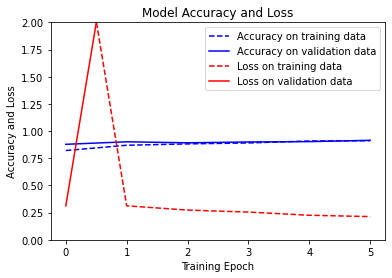

In [ ]:
plt.plot(cnn2_history.history['accuracy'], "b--", label="Accuracy on training data")
plt.plot(cnn2_history.history['val_accuracy'], "b", label="Accuracy on validation data")
plt.plot(cnn2_history.history['loss'], "r--", label="Loss on training data")
plt.plot(cnn2_history.history['val_loss'], "r", label="Loss on validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0,2)
plt.legend()
plt.show()

Report di classificazione:
                precision    recall  f1-score   support

    alessandro       0.96      0.69      0.80       118
        davide       0.68      0.96      0.79       106
       fabrice       0.97      0.89      0.93       115
unknown_person       1.00      1.00      1.00       310

      accuracy                           0.92       649
     macro avg       0.90      0.88      0.88       649
  weighted avg       0.94      0.92      0.92       649

Matrice di confusione:
[[ 81  37   0   0]
 [  2 102   2   0]
 [  1  12 102   0]
 [  0   0   1 309]]


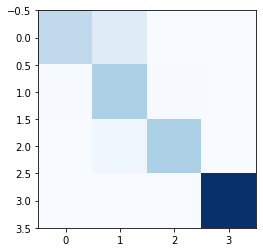

In [ ]:
# Test
y_pred = cnn2.predict(X_test_cnn)
y_pred_cr = ricateg(y_pred)
y_test_cr = ricateg(y_test)
# Report di classificazione
print("Report di classificazione:")
print(classification_report(y_test_cr, y_pred_cr))

# Matrice di confusione
print("Matrice di confusione:")
cnn2_cm = confusion_matrix(y_test_cr, y_pred_cr)
print(cnn2_cm)
plt.imshow(cnn2_cm, cmap=plt.cm.Blues)

In [ ]:
cnn2.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])
X_whole = np.concatenate((X_train_cnn, X_test_cnn), axis=0)
y_whole = np.concatenate((y_train_cnn, y_test_cnn), axis=0)
cnn2_history = cnn2.fit(X_whole, y_whole, epochs=8, batch_size=16, verbose=False)
cnn2.save(path+'cnn2')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/DSIM/recordings/cnn2/assets


# CNN on MFCCs

2-D CNNs are often used for spectral analysis, but the granularity of spectrograms requires big arrays and the image paradigm doesn't represent the intrinsic difference between the nature of time and frequency axes. 
1-D CNN on multiple features is preferred, with MFCCs representing distribution of energy in frequencies, over time.

In [ ]:
def mfcc_load_data(feature_extractor=librosa.feature.mfcc, normalize=True):

    labels = []
    features = []
    labelling = {'alessandro': 1,
                'fabrice': 2,
                'davide': 3,
                'unknown_person':0}

    for f in sorted(os.listdir('/content/drive/My Drive/DSIM/recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('/content/drive/My Drive/DSIM/recordings/' + f)
            signal = crop(signal).astype(float)
            mfcc_features = feature_extractor(signal, sr=_, n_mfcc=40)
            mfcc_features = np.asarray(mfcc_features)
            if normalize==True:
              mfcc_features = scale(mfcc_features, axis=1)
            features.append(mfcc_features)

            # Categorie
            label = f.split('_')[1]
            if label not in ('alessandro', 'fabrice', 'davide'):
                label = 'unknown_person'
            label = labelling[label]
            labels.append(label)
        else:
            print(f)

    # X: features, y: labels
    num_classes = len(labelling)
    X_train, X_test, y_train, y_test = train_test_split(np.asarray(features), np.asarray(labels), test_size=0.2, random_state=1)
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    

    return X_train, X_test, y_train, y_test, num_classes

In [ ]:
#X_train, X_test, y_train, y_test, num_classes = mfcc_load_data()

#saver(X_train,path+'X_train_mfccfeat'); saver(X_test, path+'X_test_mmfccfeat'); saver(y_train, path+'y_train_mfccfeat'); saver(y_test,path+'y_test_mlfccfeat');
X_train=loader(path+'X_train_mfccfeat'); X_test=loader(path+'X_test_mmfccfeat'); y_train=loader(path+'y_train_mfccfeat'); y_test=loader(path+'y_test_mlfccfeat'); num_classes=4;


In [ ]:
X_train.shape

(2594, 40, 259)

In [ ]:
# Conv1D necessita di (batch, sequenza, features)
X_train = np.transpose(X_train,(0,2,1))
X_test = np.transpose(X_test,(0,2,1))
X_train.shape

(2594, 259, 40)

In [ ]:
dims = (X_train.shape[1], X_train.shape[2])

cnn_mfcc = Sequential()
cnn_mfcc.add(Conv1D(filters=128, kernel_size=4, activation='relu', input_shape=dims, padding='valid'))
cnn_mfcc.add(MaxPool1D(3, padding='valid'))
cnn_mfcc.add(Conv1D(filters=128, kernel_size=4, activation='relu', padding='valid'))
cnn_mfcc.add(MaxPool1D(3, padding='valid'))
cnn_mfcc.add(Flatten())
cnn_mfcc.add(Dropout(0.5))
cnn_mfcc.add(Dense(128))
cnn_mfcc.add(Dropout(0.5))
cnn_mfcc.add(Dense(32))
cnn_mfcc.add(Dense(num_classes))
cnn_mfcc.add(Activation('softmax'))

cnn_mfcc.summary()
cnn_mfcc.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 256, 128)          20608     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 85, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 82, 128)           65664     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 3456)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [ ]:
t0 = time()
cnn_mfcc_history = cnn_mfcc.fit(X_train, y_train, epochs=6, batch_size=32, verbose=True, validation_data=(X_test, y_test))
print("Addestramento completato in %0.3fs" % (time() - t0))

Epoch 1/6
82/82 [==============================] - 1s 9ms/step - loss: 0.4153 - accuracy: 0.8901 - val_loss: 0.0751 - val_accuracy: 0.9692
Epoch 2/6
82/82 [==============================] - 0s 5ms/step - loss: 0.0457 - accuracy: 0.9827 - val_loss: 0.0364 - val_accuracy: 0.9846
Epoch 3/6
82/82 [==============================] - 0s 5ms/step - loss: 0.0176 - accuracy: 0.9938 - val_loss: 0.0310 - val_accuracy: 0.9908
Epoch 4/6
82/82 [==============================] - 0s 5ms/step - loss: 0.0134 - accuracy: 0.9946 - val_loss: 0.0156 - val_accuracy: 0.9938
Epoch 5/6
82/82 [==============================] - 0s 5ms/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0429 - val_accuracy: 0.9908
Epoch 6/6
82/82 [==============================] - 0s 5ms/step - loss: 0.0063 - accuracy: 0.9969 - val_loss: 0.0452 - val_accuracy: 0.9908
Addestramento completato in 3.666s


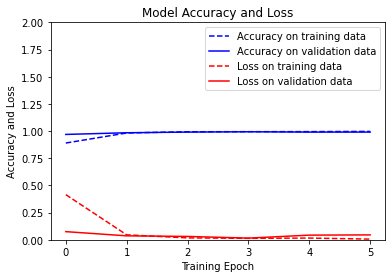

In [ ]:
plt.plot(cnn_mfcc_history.history['accuracy'], "b--", label="Accuracy on training data")
plt.plot(cnn_mfcc_history.history['val_accuracy'], "b", label="Accuracy on validation data")
plt.plot(cnn_mfcc_history.history['loss'], "r--", label="Loss on training data")
plt.plot(cnn_mfcc_history.history['val_loss'], "r", label="Loss on validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0,2)
plt.legend()
plt.show()

Report di classificazione:
                precision    recall  f1-score   support

    alessandro       1.00      0.95      0.97       118
        davide       0.95      1.00      0.97       106
       fabrice       1.00      1.00      1.00       115
unknown_person       1.00      1.00      1.00       310

      accuracy                           0.99       649
     macro avg       0.99      0.99      0.99       649
  weighted avg       0.99      0.99      0.99       649

Matrice di confusione:
[[112   6   0   0]
 [  0 106   0   0]
 [  0   0 115   0]
 [  0   0   0 310]]


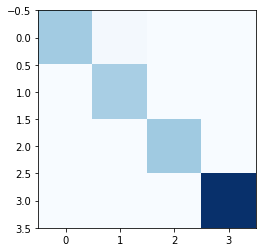

In [ ]:
# Test
y_pred = cnn_mfcc.predict(X_test)
y_pred_cr = ricateg(y_pred)
y_test_cr = ricateg(y_test)
# Report di classificazione
print("Report di classificazione:")
print(classification_report(y_test_cr, y_pred_cr))

# Matrice di confusione
print("Matrice di confusione:")
cnn_mfcc_cm = confusion_matrix(y_test_cr, y_pred_cr)
print(cnn_mfcc_cm)
plt.imshow(cnn_mfcc_cm, cmap=plt.cm.Blues)

In [ ]:
cnn_mfcc.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])
X_whole = np.concatenate((X_train, X_test), axis=0)
y_whole = np.concatenate((y_train, y_test), axis=0)
cnn_mfcc_history = cnn_mfcc.fit(X_whole, y_whole, epochs=8, batch_size=16, verbose=False)
cnn_mfcc.save(path+'cnn_mfcc')

INFO:tensorflow:Assets written to: /content/drive/My Drive/DSIM/recordings/cnn_mfcc/assets


We have almost perfect results in a few epochs, for less than 5% of the parameters necessary for the previous 1-D Convolutional architecture, and without the needs of 2-D architectures and spectrogram computations and memory space requirements.